*IMPORTANT*    
Please do not ping or trace the IP addresses in this analysis, especially from company network or VPN. 

This analysis uses SQLite database file created from step01 and step02. The file name checked in with this project is aydevmo_net_log_01.db.   

As of 1/31/2023, SQLAlchemy 2.0 has some compatibility issues with Pandas so we downgraded SQLAlchemy version to 1.4.46.   

pip uninstall sqlalchemy   
pip install --force-reinstall -v "sqlalchemy==1.4.46"   

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import geopandas as gpd

import sqlalchemy as sqla

---
Firstly, load the SQLite database file. This file contains two tables we produced in the log processing phase.    
    
Examine the "hosts" table. We didn't populate the hostname so it's empty. It would be interesting to write a service handling reverse DNS lookup and populate it in the future.

In [3]:
sql_engine = sqla.create_engine("sqlite:///aydevmo_net_log_01.db")

df_host = pd.read_sql("select * from hosts limit 100", sql_engine)

df_host.head()

,ipv4_id,ipv4_string,hostname,latitude,longitude,country_code,country,city
0,19988767,1.49.1.31,,31.2420,121.4760,CN,China,Huangpu
1,20468882,1.56.84.146,,45.7500,126.6500,CN,China,Harbin
2,37239577,2.56.59.25,,52.3824,4.8995,NL,Netherlands,None
3,40030346,2.98.208.138,,51.5538,-0.3102,GB,United Kingdom,Wembley
4,85797893,5.29.44.5,,32.0236,34.7522,IL,Israel,Bat Yam


---
Examine the "log_records" table.    
     
This table tells limited information. The log_number is a number assigned by Cisco ASA for this type of incident (not useful in our analysis).     
     
The source and destination number are 4-byte integers representing IPv4 addresses.    
     
destination and destination_port represent our local host and port being scanned.    
     
We don't care about source_port since it's from the remote scanners/attackers and means little to us so it's not tracked.     

In [4]:
df_rec = pd.read_sql("select * from log_records limit 200", sql_engine)

df_rec.head()

,log_id,created_on,log_number,protocol,source,destination,destination_port,occurrence,sum_minutes
0,1,2021-06-21 20:55:54.000000,106023,tcp,1547683146,3232242186,12489,1,0
1,2,2021-06-21 20:55:58.000000,106023,tcp,1509467513,3232242231,7742,1,0
2,3,2021-06-21 20:56:05.000000,106023,tcp,2818082075,3232241677,40000,1,0
3,4,2021-06-21 20:56:07.000000,106023,tcp,1509467513,3232241714,7007,1,0
4,5,2021-06-21 20:56:10.000000,106023,tcp,1509467462,3232241674,10040,1,0


---
"log_records" table alone would not provide useful information. We'd need to join it with "hosts" table.    
    
We use "source" field in "log_records" table, and "ipv4_id" field in "hosts" table to join these two tables. These two fields both track the IPv4 addresses of the remote scanners/attackers. 
     
Then we will see more interesting result. 

In [5]:
df_probes = pd.read_sql("select * from log_records join hosts on log_records.source = hosts.ipv4_id", sql_engine)

df_probes.head()

,log_id,created_on,log_number,protocol,source,destination,destination_port,occurrence,sum_minutes,ipv4_id,ipv4_string,hostname,latitude,longitude,country_code,country,city
0,1,2021-06-21 20:55:54.000000,106023,tcp,1547683146,3232242186,12489,1,0,1547683146,92.63.197.74,,55.7386,37.6068,RU,Russia,None
1,2,2021-06-21 20:55:58.000000,106023,tcp,1509467513,3232242231,7742,1,0,1509467513,89.248.165.121,,52.3759,4.8975,NL,Netherlands,Amsterdam
2,3,2021-06-21 20:56:05.000000,106023,tcp,2818082075,3232241677,40000,1,0,2818082075,167.248.133.27,,37.7510,-97.8220,US,United States,None
3,4,2021-06-21 20:56:07.000000,106023,tcp,1509467513,3232241714,7007,1,0,1509467513,89.248.165.121,,52.3759,4.8975,NL,Netherlands,Amsterdam
4,5,2021-06-21 20:56:10.000000,106023,tcp,1509467462,3232241674,10040,1,0,1509467462,89.248.165.70,,52.3759,4.8975,NL,Netherlands,Amsterdam


---
Check the record count. We see most columns have 6370 records. Only "city" column has 3520 records. This is because the GeoIP data we used doesn't have this information. 

In [6]:
df_probes.count()

log_id              6370
created_on          6370
log_number          6370
protocol            6370
source              6370
destination         6370
destination_port    6370
occurrence          6370
sum_minutes         6370
ipv4_id             6370
ipv4_string         6370
hostname            6370
latitude            6370
longitude           6370
country_code        6370
country             6370
city                3520
dtype: int64

---
When we saved the destination IPv4 addresses in our database, we saved it as an integer to reduce file size and increase performance, but it's not human readable. Let's convert it back to the 4-number format that we're familiar with.    
    
The function below feeds this 4-byte integer into a loop. The loop bitwise AND's the integer with 0xff to get the rightmost byte, and right-shift the rest for the next iteration. At the end, we'll break the 4-byte integer into 4 one-byte numbers and get the IPv4 address.  
    
This function is not the most efficient one because it performs one uncessary right-shift operation at the last iteration of the loop, but it looks very simple to the eye.

In [7]:
def ipv4_int_to_string(num):
    '''Convert integer to IPv4 string'''
    result = []
    for i in range(4):
        result.insert(0, str(num & 0xff) )
        num >>= 8
    return '.'.join(result)

df_probes['dest_ipv4_string'] = df_probes['destination'].apply(ipv4_int_to_string)


---
It may be useful to categorize each IPv4 address into /24 CIDR subnets because it's a common segment size an ISP would use. We'll just clear the rightmost byte of the integer (num & 0xff.ff.ff.00) and re-use the previous function. Here we again abused CPU on the less-performance side :-D 

In [8]:
def ipv4_int_to_string_subnet_24(num):
    '''Convert integer to IPv4 /24 subnet string'''
    return ipv4_int_to_string( num & 0xffffff00 )

df_probes['src_subnet_24'] = df_probes['source'].apply(ipv4_int_to_string_subnet_24)

---
Drop unnecessary columns.

In [9]:
df_probes = df_probes.drop(columns=['log_number', 'sum_minutes', 'ipv4_id', 'hostname'])

---
Rename column "ipv4_string" to "src_ipv4_string" so we know it's the source/scanner/attacker's IPv4 address. 

In [10]:
df_probes.rename(columns={'ipv4_string': 'src_ipv4_string'}, inplace=True)

cols = df_probes.columns.tolist()

cols

['log_id',
 'created_on',
 'protocol',
 'source',
 'destination',
 'destination_port',
 'occurrence',
 'src_ipv4_string',
 'latitude',
 'longitude',
 'country_code',
 'country',
 'city',
 'dest_ipv4_string',
 'src_subnet_24']

---
Rearrange the sequence of the columns so it's more readable. 

In [11]:
cols = \
['log_id',
 'created_on',
 'protocol',
 'source',
 'destination',
 'src_ipv4_string',
 'src_subnet_24',
 'dest_ipv4_string',
 'destination_port',
 'occurrence',
 'latitude',
 'longitude',
 'country_code',
 'country',
 'city' ]

df_probes = df_probes[cols]

df_probes.head()

,log_id,created_on,protocol,source,destination,src_ipv4_string,src_subnet_24,dest_ipv4_string,destination_port,occurrence,latitude,longitude,country_code,country,city
0,1,2021-06-21 20:55:54.000000,tcp,1547683146,3232242186,92.63.197.74,92.63.197.0,192.168.26.10,12489,1,55.7386,37.6068,RU,Russia,None
1,2,2021-06-21 20:55:58.000000,tcp,1509467513,3232242231,89.248.165.121,89.248.165.0,192.168.26.55,7742,1,52.3759,4.8975,NL,Netherlands,Amsterdam
2,3,2021-06-21 20:56:05.000000,tcp,2818082075,3232241677,167.248.133.27,167.248.133.0,192.168.24.13,40000,1,37.7510,-97.8220,US,United States,None
3,4,2021-06-21 20:56:07.000000,tcp,1509467513,3232241714,89.248.165.121,89.248.165.0,192.168.24.50,7007,1,52.3759,4.8975,NL,Netherlands,Amsterdam
4,5,2021-06-21 20:56:10.000000,tcp,1509467462,3232241674,89.248.165.70,89.248.165.0,192.168.24.10,10040,1,52.3759,4.8975,NL,Netherlands,Amsterdam


---
What protocol is the scanner's top interest? The answer is "TCP". It shows 5950 scans. 
(Well, we only tracked TCP, UDP, and ICMP in our dataset anyways.)

In [12]:
df_probes['protocol'].value_counts().nlargest(20)

tcp     5950
udp      381
icmp      39
Name: protocol, dtype: int64

---
What ports are the top interests of the scanners?    
Port 22: SSH    
Port 5060: SIP (Internet phone)    
Port 6379: Redis    
Port 80: HTTP    
Port 389: LDAP

In [13]:
df_probes['destination_port'].value_counts().nlargest(20)

22       109
5060      80
6379      74
80        73
389       67
123       44
53        41
1433      39
445       38
443       35
50802     30
3389      29
8080      28
10443     28
2048      27
2375      26
61969     23
8089      21
69        20
8081      19
Name: destination_port, dtype: int64

---
List the top countries the scanners are coming from. Some of them could be botnets, which are vulnerable victims who got their devices infected with virus. 

In [14]:
df_probes['country_code'].value_counts().nlargest(20)

RU    2138
NL    1836
US    1060
CN     256
UA     197
BG     114
GB     104
PA      73
DE      66
IN      51
CA      49
BR      43
FR      39
        38
MX      29
RO      28
SG      25
AE      18
PT      15
NG      15
Name: country_code, dtype: int64

---
List the top /24 subnets the scanners are coming from. 

In [15]:
df_probes['src_subnet_24'].value_counts().nlargest(20)

89.248.165.0     1523
45.134.26.0       904
45.146.165.0      191
185.191.34.0      186
193.27.228.0      183
162.142.125.0     126
167.248.133.0     106
74.120.14.0       102
5.188.206.0        94
45.143.200.0       90
103.145.13.0       81
92.63.197.0        79
45.146.164.0       71
193.27.229.0       67
45.155.205.0       65
45.143.203.0       60
45.129.136.0       60
89.248.168.0       58
183.136.225.0      57
185.153.199.0      55
Name: src_subnet_24, dtype: int64

---
Let's pick the top one /24 subnet and get more details.

In [16]:
df_probes[df_probes['src_subnet_24']=='89.248.165.0']

,log_id,created_on,protocol,source,destination,src_ipv4_string,src_subnet_24,dest_ipv4_string,destination_port,occurrence,latitude,longitude,country_code,country,city
1,2,2021-06-21 20:55:58.000000,tcp,1509467513,3232242231,89.248.165.121,89.248.165.0,192.168.26.55,7742,1,52.3759,4.8975,NL,Netherlands,Amsterdam
3,4,2021-06-21 20:56:07.000000,tcp,1509467513,3232241714,89.248.165.121,89.248.165.0,192.168.24.50,7007,1,52.3759,4.8975,NL,Netherlands,Amsterdam
4,5,2021-06-21 20:56:10.000000,tcp,1509467462,3232241674,89.248.165.70,89.248.165.0,192.168.24.10,10040,1,52.3759,4.8975,NL,Netherlands,Amsterdam
11,12,2021-06-21 20:56:25.000000,tcp,1509467592,3232241677,89.248.165.200,89.248.165.0,192.168.24.13,4666,1,52.3759,4.8975,NL,Netherlands,Amsterdam
12,13,2021-06-21 20:56:26.000000,tcp,1509467513,3232242597,89.248.165.121,89.248.165.0,192.168.27.165,7007,1,52.3759,4.8975,NL,Netherlands,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6326,6327,2021-06-21 23:58:53.000000,tcp,1509467634,3232241677,89.248.165.242,89.248.165.0,192.168.24.13,58616,1,52.3759,4.8975,NL,Netherlands,Amsterdam
6335,6336,2021-06-21 23:59:00.000000,tcp,1509467513,3232242186,89.248.165.121,89.248.165.0,192.168.26.10,7623,1,52.3759,4.8975,NL,Netherlands,Amsterdam
6357,6358,2021-06-21 23:59:41.000000,tcp,1509467513,3232241714,89.248.165.121,89.248.165.0,192.168.24.50,7772,1,52.3759,4.8975,NL,Netherlands,Amsterdam
6359,6360,2021-06-21 23:59:43.000000,tcp,1509467513,3232241677,89.248.165.121,89.248.165.0,192.168.24.13,7830,1,52.3759,4.8975,NL,Netherlands,Amsterdam


---
What are the IPv4 addresses the scanners use from the top one /24 subnet?

In [17]:
df_probes[df_probes['src_subnet_24']=='89.248.165.0'].src_ipv4_string.value_counts()

89.248.165.121    670
89.248.165.83      62
89.248.165.87      60
89.248.165.249     52
89.248.165.109     52
89.248.165.110     47
89.248.165.108     45
89.248.165.75      43
89.248.165.72      36
89.248.165.8       35
89.248.165.242     35
89.248.165.70      34
89.248.165.86      31
89.248.165.247     30
89.248.165.204     29
89.248.165.244     28
89.248.165.53      22
89.248.165.202     21
89.248.165.77      20
89.248.165.163     20
89.248.165.200     19
89.248.165.245     17
89.248.165.203     17
89.248.165.85      16
89.248.165.104     15
89.248.165.51      13
89.248.165.118     12
89.248.165.122     12
89.248.165.164      9
89.248.165.52       7
89.248.165.132      4
89.248.165.59       4
89.248.165.61       3
89.248.165.134      2
89.248.165.150      1
Name: src_ipv4_string, dtype: int64

---
What are the top 5 local hosts being scanned? 

In [18]:
df_probes['dest_ipv4_string'].value_counts().nlargest(5)


192.168.24.13     1082
192.168.27.165    1068
192.168.26.55     1065
192.168.24.50     1054
192.168.24.10     1046
Name: dest_ipv4_string, dtype: int64

---
Get details of the scans the top one local host received from the top one remote subnet. 

In [22]:
df_filtered = df_probes[ (df_probes['dest_ipv4_string']=='192.168.24.13') & (df_probes['src_subnet_24']=='89.248.165.0') ]

df_filtered

,log_id,created_on,protocol,source,destination,src_ipv4_string,src_subnet_24,dest_ipv4_string,destination_port,occurrence,latitude,longitude,country_code,country,city
11,12,2021-06-21 20:56:25.000000,tcp,1509467592,3232241677,89.248.165.200,89.248.165.0,192.168.24.13,4666,1,52.3759,4.8975,NL,Netherlands,Amsterdam
23,24,2021-06-21 20:56:40.000000,tcp,1509467513,3232241677,89.248.165.121,89.248.165.0,192.168.24.13,7742,1,52.3759,4.8975,NL,Netherlands,Amsterdam
72,73,2021-06-21 20:58:18.000000,tcp,1509467475,3232241677,89.248.165.83,89.248.165.0,192.168.24.13,58289,1,52.3759,4.8975,NL,Netherlands,Amsterdam
100,101,2021-06-21 20:58:47.000000,tcp,1509467467,3232241677,89.248.165.75,89.248.165.0,192.168.24.13,61237,1,52.3759,4.8975,NL,Netherlands,Amsterdam
103,104,2021-06-21 20:58:50.000000,tcp,1509467513,3232241677,89.248.165.121,89.248.165.0,192.168.24.13,7546,1,52.3759,4.8975,NL,Netherlands,Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6310,6311,2021-06-21 23:58:30.000000,tcp,1509467513,3232241677,89.248.165.121,89.248.165.0,192.168.24.13,7623,1,52.3759,4.8975,NL,Netherlands,Amsterdam
6316,6317,2021-06-21 23:58:37.000000,tcp,1509467475,3232241677,89.248.165.83,89.248.165.0,192.168.24.13,58312,1,52.3759,4.8975,NL,Netherlands,Amsterdam
6324,6325,2021-06-21 23:58:49.000000,tcp,1509467513,3232241677,89.248.165.121,89.248.165.0,192.168.24.13,7811,1,52.3759,4.8975,NL,Netherlands,Amsterdam
6326,6327,2021-06-21 23:58:53.000000,tcp,1509467634,3232241677,89.248.165.242,89.248.165.0,192.168.24.13,58616,1,52.3759,4.8975,NL,Netherlands,Amsterdam


---
Did the remote scanner spread workload across its hosts? 

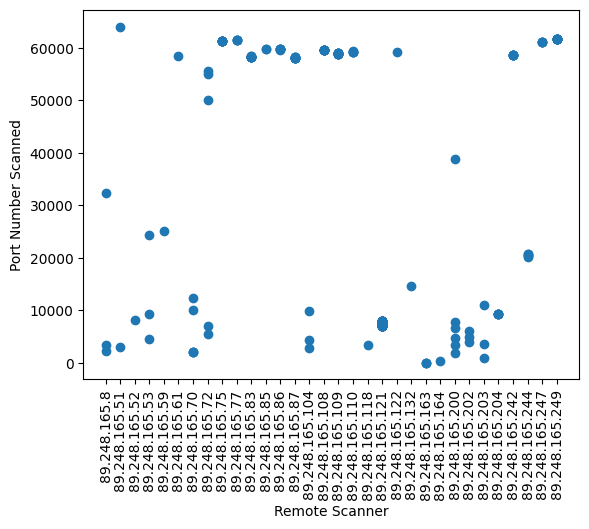

In [24]:
df_filtered = df_filtered.sort_values(by='source')

x = df_filtered['src_ipv4_string']
y = df_filtered['destination_port']
plt.scatter(x, y, alpha=1)
plt.xticks(rotation=90)
plt.ylabel("Port Number Scanned")
plt.xlabel("Remote Scanner")
plt.show()

---
Prepare to draw the map. Not sure how to leave the keys in the dataframe after grouping them so I spent some time and gave it a few tries.  

In [97]:
df_geo = df_probes.groupby(['latitude','longitude', 'country_code']).occurrence.agg(['count'])

df_geo = df_geo.sort_values(by='count', ascending=False)

#df_geo['latitude'] = [ x for (x, y, z) in df_geo.index ]
#df_geo['longitude'] = [ y for (x, y, z) in df_geo.index ]
#df_geo['country_code'] = [ z for (x, y, z) in df_geo.index ]

#df_geo['latitude', 'longitude', 'country_code'] = [ [x, y, z] for (x, y, z) in df_geo.index]

#df_geo['latitude', 'longitude', 'country_code'] =  list(zip(*df_geo.index))  #error

#df_geo['latitude', 'longitude', 'country_code'] =  df_geo.index

#df_geo[['latitude', 'longitude', 'country_code']] =  df_geo.index  #error

#df_geo[['latitude', 'longitude', 'country_code']] = [ (x, y, z) for (x, y, z) in df_geo.index]  # okay

df_geo[['latitude', 'longitude', 'country_code']] = [ [x, y, z] for (x, y, z) in df_geo.index]

df_geo = df_geo.sort_values(by='count')

df_geo

,,,count,latitude,longitude,country_code
latitude,longitude,country_code,,,,
62.3772,17.3203,SE,1,62.3772,17.3203,SE
49.8390,24.0191,UA,1,49.839,24.0191,UA
45.0914,7.6639,IT,1,45.0914,7.6639,IT
44.9837,19.6146,RS,1,44.9837,19.6146,RS
50.1103,8.7147,DE,1,50.1103,8.7147,DE
...,...,...,...,...,...,...
37.7308,-122.3838,US,160,37.7308,-122.3838,US
55.7483,37.6171,RU,371,55.7483,37.6171,RU
37.7510,-97.8220,US,444,37.751,-97.822,US


---
Reference1:    
https://github.com/udiy/blogposts/tree/main/Easy%20map     

Reference2:    
https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html     
     
Found online resources for drawing the world map. 


<AxesSubplot: >

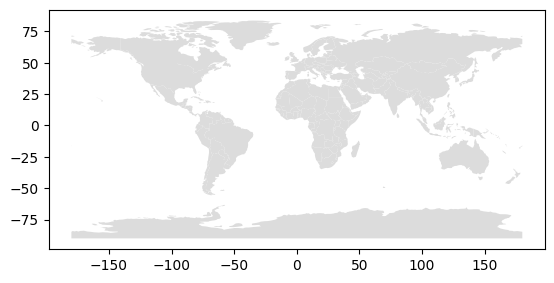

In [93]:
world_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

world_map.plot(color="gainsboro")

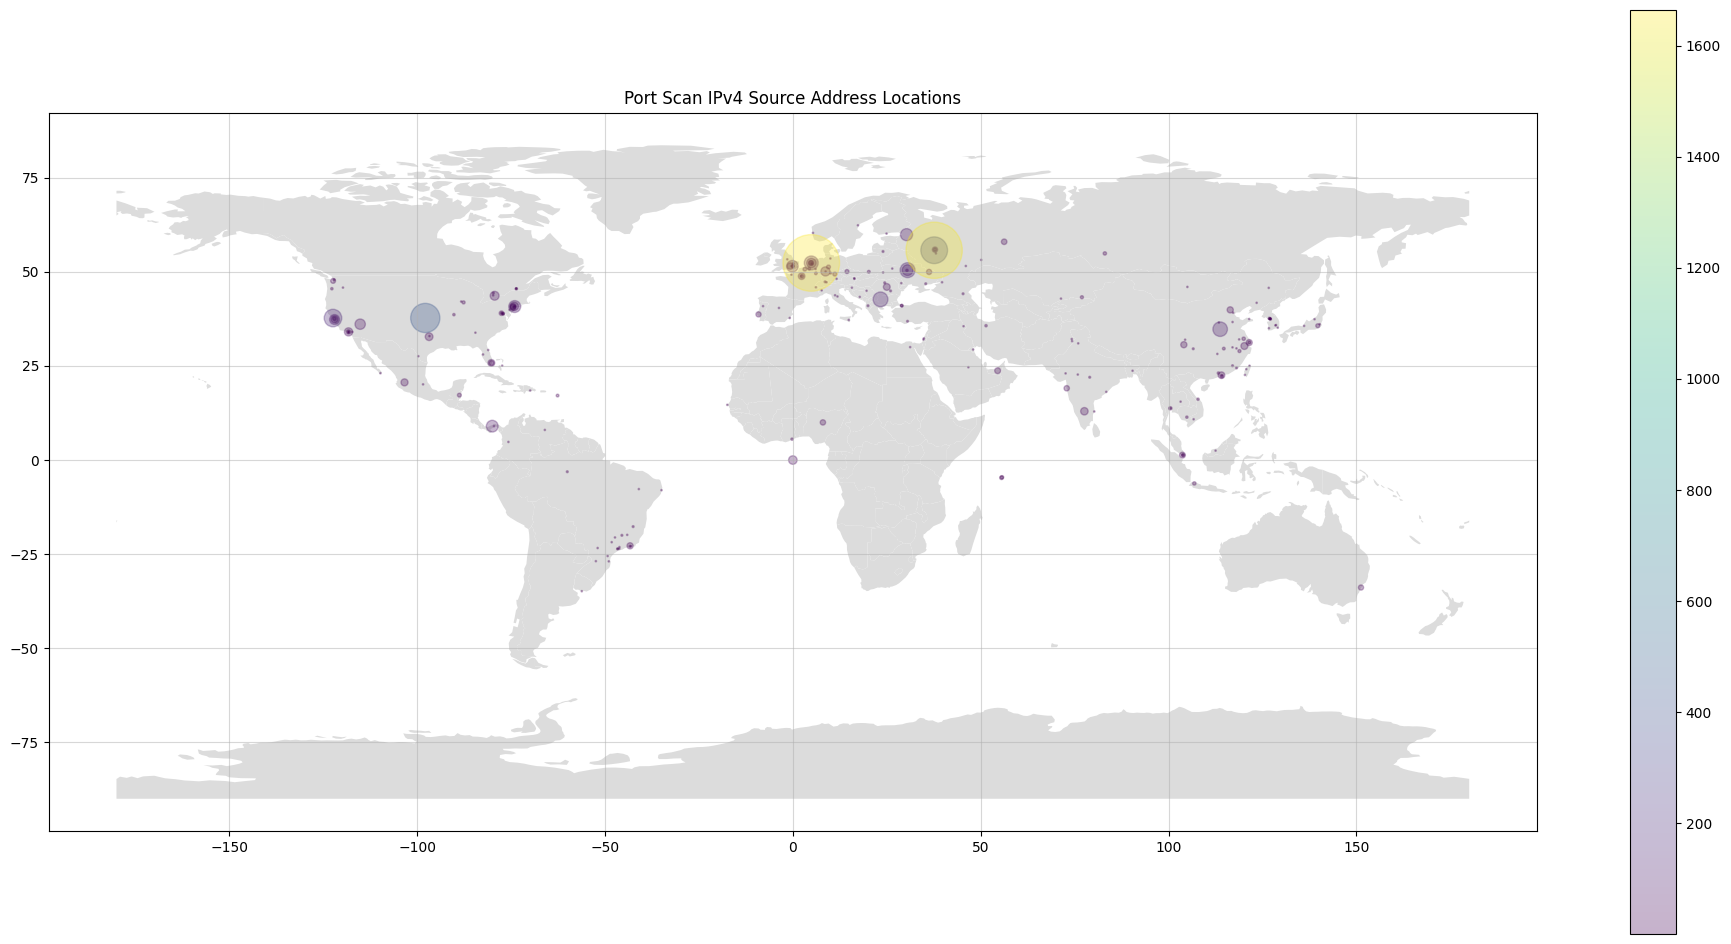

In [98]:
# initialize an axis
fig, ax = plt.subplots(figsize=(24,12))

# plot map on axis
world_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world_map.plot(color="gainsboro", ax=ax)

# plot points
# df_geo.plot(x="longitude", y="latitude", kind="scatter", c="count", colormap="plasma", 
#        title=f"Port Scan IPv4 Source Address Locations", ax=ax)

y = df_geo['latitude']
x = df_geo['longitude']
colors = df_geo['count']
sizes = df_geo['count']

plt.scatter(x, y, c=colors, s=sizes, alpha=0.3, cmap='viridis')
plt.colorbar();  # show color scale

plt.title("Port Scan IPv4 Source Address Locations")

# add grid
ax.grid(visible=True, alpha=0.5)

plt.show()